<a href="https://colab.research.google.com/github/xAn-x/Language-Modelling-Zero-to-One/blob/master/04_Transformers_for_Language_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [4]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-08-27 02:43:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  5.14MB/s    in 0.2s    

2024-08-27 02:43:02 (5.14 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [5]:
with open('input.txt','r',encoding='utf-8') as f:
  text=f.read()

In [6]:
print(text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [7]:
vocab=sorted(list(set(text)))
vocab_size=len(vocab)

print(f"vocab_size: {vocab_size}")
print(f"vocab: {vocab}")

vocab_size: 65
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
stoi={ch:i for i,ch in enumerate(vocab)}
itos={i:ch for i,ch in enumerate(vocab)}

def encode(s):
  return [stoi[ch] for ch in s]

def decode(l):
  return ''.join([itos[i] for i in l])

In [9]:
print(encode("hello, there"))
print(decode(encode("hello, there")))

[46, 43, 50, 50, 53, 6, 1, 58, 46, 43, 56, 43]
hello, there


In [10]:
data=torch.tensor(encode(text),dtype=torch.long)
print(data.shape,data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [11]:
train_size=int(0.9*len(data))
train_data=data[:train_size]
val_data=data[train_size:]

print(f"train_size: {train_size}")
print(f"val_size: {len(val_data)}")

train_size: 1003854
val_size: 111540


In [12]:
def get_batch(batch_size,block_size,split="train"):
  if split=="train":
    data=train_data
  else:
    data=val_data

  n=len(data)
  ix=torch.randint(n-block_size-1,(batch_size,))
  x=torch.stack([data[i:i+block_size] for i in ix])
  y=torch.stack([data[i+1:i+block_size+1] for i in ix])

  return x,y

In [13]:
batch_size,block_size=8,64
x,y=get_batch(batch_size,block_size)

print(f"x.shape: {x.shape}")
print(f"y.shape: {y.shape}")
print('\n',".*."*15,end='\n\n')
print(f"x:{x}\n")
print(f"y:{y}\n")

x.shape: torch.Size([8, 64])
y.shape: torch.Size([8, 64])

 .*..*..*..*..*..*..*..*..*..*..*..*..*..*..*.

x:tensor([[56,  1, 57, 53, 59, 52, 42,  6,  5,  1, 40, 43, 41, 39, 59, 57, 43,  1,
         51, 59, 57, 47, 41, 47, 39, 52, 57,  1, 57, 53, 59, 52, 42,  1, 44, 53,
         56,  1, 57, 47, 50, 60, 43, 56,  8,  0,  0, 28, 17, 32, 17, 30, 10,  0,
         28, 56, 43, 58, 58, 63,  1, 58, 53, 53],
        [57, 58,  1, 58, 53,  1, 15, 53, 56, 47, 53, 50, 47,  1, 40, 39, 41, 49,
         10,  1, 57, 43, 52, 42,  1, 59, 57,  1, 58, 53,  1, 30, 53, 51, 43,  0,
         32, 46, 43,  1, 40, 43, 57, 58,  6,  1, 61, 47, 58, 46,  1, 61, 46, 53,
         51,  1, 61, 43,  1, 51, 39, 63,  1, 39],
        [53, 52,  6,  1, 57, 58, 56, 47, 49, 43,  1, 59, 54,  2,  0,  0, 16, 27,
         30, 15, 13, 31, 10,  0, 25, 53, 54, 57, 39,  1, 51, 59, 57, 58,  1, 40,
         43,  1, 63, 53, 59, 56,  1, 51, 47, 57, 58, 56, 43, 57, 57, 10,  1, 51,
         39, 56, 56, 63,  6,  1, 45, 39, 56, 50],
        [27,

In [14]:
decode(x[1].tolist())

'st to Corioli back: send us to Rome\nThe best, with whom we may a'

## `Transformer-Model-Architecture:`

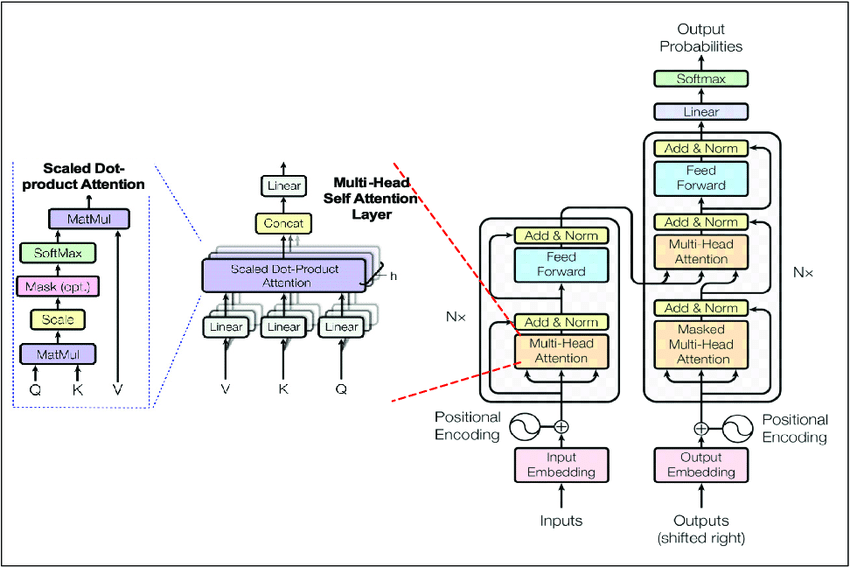

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContextualEmbeddings(nn.Module):
  def __init__(self, vocab_size,context_len,embedding_dim) -> None:
    super().__init__()
    self.word_embeddings=nn.Embedding(vocab_size,embedding_dim)
    self.positonal_embeddings=nn.Embedding(context_len,embedding_dim)
    self.register_buffer("positions",torch.arange(context_len))

  def forward(self,x):
    # x.shape: (B,T)
    return self.word_embeddings(x)+self.positonal_embeddings(self.positions) # out.shape:(B,T,C)

class AttentionHead(nn.Module):
  def __init__(self,embedding_dim,head_size):
    super().__init__()
    self.head_size=head_size
    self.query=nn.Linear(embedding_dim,head_size)
    self.key=nn.Linear(embedding_dim,head_size)
    self.value=nn.Linear(embedding_dim,head_size)

  @staticmethod
  def attention(q,k,v,head_size,mask):
    # q:(B,T,H) k:(B,H,T)
    weights= q @ k.transpose(-2,-1) / head_size**0.5
    if mask is not None:
      weights=weights.masked_fill(mask==0,float('-inf'))
    weights=weights.softmax(dim=-1)
    attention_scores=weights @ v
    return attention_scores

  def forward(self,x,mask=None):
    k=self.key(x)
    v=self.value(x)
    q=self.query(x)

    attention_scores=AttentionHead.attention(q,k,v,self.head_size,mask)
    return attention_scores


class MultiHeadAttention(nn.Module):
  def __init__(self,embedding_dim,n_heads):
    super().__init__()
    assert embedding_dim%n_heads==0,f"embedding_dim({embedding_dim}) can't be divided into n_heads({n_heads})"
    head_size=embedding_dim//n_heads
    self.attention_heads=nn.ModuleList([AttentionHead(embedding_dim,head_size) for head in range(n_heads)])

  def forward(self,x,mask=None):
    out=[]
    for attn_head in self.attention_heads:
      out.append(attn_head(x,mask))
    out=torch.cat(out,dim=-1)
    return out


class ProjectionLayer(nn.Module):
  def __init__(self,in_features,projection_fact=4):
    super().__init__()
    self.fc=nn.Sequential(
      nn.Linear(in_features,in_features*projection_fact),
      nn.Linear(in_features*projection_fact,in_features),
      nn.Dropout(0.3),
    )

  def forward(self,x):
    return self.fc(x)


class DecoderBlock(nn.Module):
  def __init__(self,embedding_dim,n_heads,projection_fact=4):
    super().__init__()
    head_size=embedding_dim//n_heads
    self.ln1=nn.LayerNorm(embedding_dim)
    self.masked_attention=MultiHeadAttention(embedding_dim,n_heads)
    self.fc=ProjectionLayer(embedding_dim,projection_fact)
    self.ln2=nn.LayerNorm(embedding_dim)

  def forward(self,x,mask):
    x=x+self.ln1(x)
    x=x+self.masked_attention(self.ln2(x),mask)
    x=self.fc(x)
    return x

class Decoder(nn.Module):
  def __init__(self,embedding_dim,n_blocks,n_heads,projection_fact=4):
    super().__init__()
    self.decoder=nn.ModuleList([DecoderBlock(embedding_dim,n_heads,projection_fact) for block in range(n_blocks)])

  def forward(self,x,mask):
    for block in self.decoder:
      x=block(x,mask)
    return x

In [42]:
class Model(nn.Module):
  def __init__(self,vocab_size,block_size,n_embed,n_heads,n_layers,projection_factor=4):
    super().__init__()
    self.vocab_size=vocab_size
    self.block_size=block_size
    self.n_heads=n_heads
    self.n_layers=n_layers

    self.embeddings=ContextualEmbeddings(vocab_size,block_size,n_embed)
    self.decoder=Decoder(n_embed,n_layers,n_heads,projection_factor)
    self.norm=nn.LayerNorm(n_embed)
    self.fc=nn.Linear(n_embed,vocab_size)
    self.register_buffer("mask",torch.tril(torch.ones(block_size,block_size)))


  def forward(self, x, targets=None):
    x = self.embeddings(x)
    x = self.decoder(x,self.mask)
    x = self.fc(self.norm(x))
    loss = None
    if targets is not None:
        x = x.view(-1, x.shape[-1])
        targets = targets.view(-1)
        loss = F.cross_entropy(x,targets)
    return x, loss

In [61]:
batch_size=64
block_size=256
n_embed=128
vocab_size=65
n_heads=8
n_layers=5
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=Model(vocab_size,block_size,n_embed,n_heads,n_layers)

print(device)
model.to(device)

cuda


Model(
  (embeddings): ContextualEmbeddings(
    (word_embeddings): Embedding(65, 128)
    (positonal_embeddings): Embedding(256, 128)
  )
  (decoder): Decoder(
    (decoder): ModuleList(
      (0-4): 5 x DecoderBlock(
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (masked_attention): MultiHeadAttention(
          (attention_heads): ModuleList(
            (0-7): 8 x AttentionHead(
              (query): Linear(in_features=128, out_features=16, bias=True)
              (key): Linear(in_features=128, out_features=16, bias=True)
              (value): Linear(in_features=128, out_features=16, bias=True)
            )
          )
        )
        (fc): ProjectionLayer(
          (fc): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=128, bias=True)
            (2): Dropout(p=0.3, inplace=False)
          )
        )
        (ln2): LayerNorm((128,), eps=1e-05, elementwise_af

In [62]:
sum(p.numel() for p in model.parameters())

958529

In [63]:
# Dev-Test-Run
X,y=get_batch(batch_size,block_size)
X,y=X.to(device),y.to(device)


logits,loss=model(X,y)
logits.shape,loss

(torch.Size([16384, 65]),
 tensor(4.3694, device='cuda:0', grad_fn=<NllLossBackward0>))

In [68]:
# Define the optimizer and the learning rate scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
optimizer = torch.optim.AdamW(model.parameters(),1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=5000, eta_min=0)

epochs=5000
eval_interval=5
log_every_kth_epoch=500
save_every_kth_epoch=2500

In [69]:
@torch.no_grad()
def evaluate(model,eval_interval):
  model.eval()
  for split in ["train","val"]:
    losses=[]
    for epoch in range(eval_interval):
      x,y=get_batch(batch_size,block_size,split)
      x,y=x.to(device),y.to(device)

      logits,loss=model(x,y)
      losses.append(loss.item())
    losses=np.array(losses)
    print(f"{split}_loss:{losses.mean():.2f}")



def train():
  history={"train_loss":[],"val_loss":[]}
  for epoch in range(epochs):
    # zero-grad
    optimizer.zero_grad()

    model.train()
    X,y=get_batch(batch_size,block_size)
    X,y=X.to(device),y.to(device)
    logits,loss=model(X,y)

    # backward-pass
    loss.backward()
    optimizer.step()

    # Update the learning rate
    scheduler.step()

    model.eval()
    with torch.no_grad():
      X,y=get_batch(batch_size,block_size,"valid")
      X,y=X.to(device),y.to(device)
      logits,val_loss=model(X,y)

    history["train_loss"].append(loss.item())
    history["val_loss"].append(val_loss.item())

    if (epoch+1)% log_every_kth_epoch ==0:
      print(f"EPOCH: {epoch+1}/{epochs}:\n")
      evaluate(model,eval_interval)
      print()

    if (epoch+1) % save_every_kth_epoch==0:
      print("Saving Model....")
      torch.save(model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Saved Models/decoder-model.pth")
      print("Model Saved....\n")

  return history

In [70]:
history=train()

EPOCH: 500/5000:

train_loss:2.61
val_loss:2.60

EPOCH: 1000/5000:

train_loss:2.54
val_loss:2.54

EPOCH: 1500/5000:

train_loss:2.53
val_loss:2.51

EPOCH: 2000/5000:

train_loss:2.50
val_loss:2.49

EPOCH: 2500/5000:

train_loss:2.48
val_loss:2.49

Saving Model....
Model Saved....

EPOCH: 3000/5000:

train_loss:2.47
val_loss:2.47

EPOCH: 3500/5000:

train_loss:2.47
val_loss:2.47

EPOCH: 4000/5000:

train_loss:2.46
val_loss:2.46

EPOCH: 4500/5000:

train_loss:2.46
val_loss:2.47

EPOCH: 5000/5000:

train_loss:2.46
val_loss:2.45

Saving Model....
Model Saved....



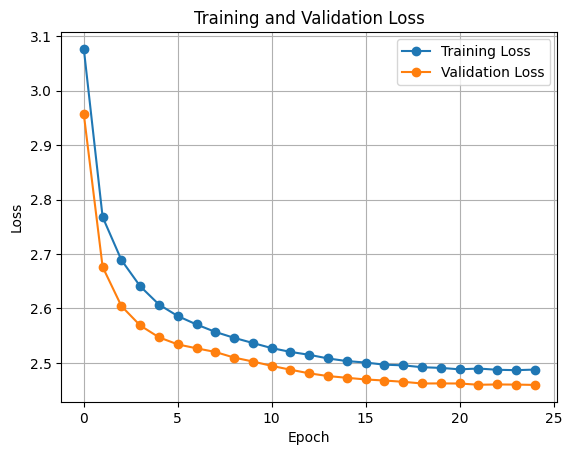

In [71]:
def plot_loss(history):
    train_loss=torch.tensor(history["train_loss"]).view(-1,200).mean(-1)
    val_loss=torch.tensor(history["val_loss"]).view(-1,200).mean(-1)

    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

In [72]:
@torch.no_grad()
def generate(n_words=300):
    model.eval()
    idx = 0
    text = train_data[idx:idx+block_size].unsqueeze(0).to(device)
    lst = []

    for _ in range(n_words):
        logits, _ = model(text)
        probs = F.softmax(logits[:, -1, :], dim=-1)  # Take the last token's logits
        new_ix = torch.multinomial(probs, num_samples=1)

        lst.append(new_ix.item())
        # Update the context, expanding up to block_size and then rolling
        if text.size(1) < block_size:
            text = torch.cat([text, new_ix], dim=1)
        else:
            text = torch.cat([text[:, 1:], new_ix], dim=1)

    return "".join(decode(lst))


In [73]:
generated_text=generate(1000)
print(generated_text)

Wherde as, s mathisote win me mofo whoule'chapade he? at gha, cousouisthent, y, anghin it f tllandy w ithant athaneng ba tine thadenerooull poubromyo forothould meshe g hanutherster band,
Thoke! moume fo wis Ne nkingh s yg o Ithise!

PUCENI ithaverd cheind bllone thas thed, pan:
SNI thapre I myof OIfe.

I busonto hanouespand, ageen it lloncat NINDIS mpad, he, t
SI the tod soayonthanuthasu gu oveayonad more t ve bandealivird metinghee

Wh achee bar t istheshar feioun sthe ipe, t:
Aithut an ort ichit m Rowe ns'oud masu tooot, teave theefoupe;
Onmonom he thethor fk.


miorn?
HAKImat wsu prthas ak IOLUCUS:
I crd teno challlrdro watouthemeayoomeitaly g gal.
Islindt s. leatharg ghillevet thenye shille soo amy t themithas.



MUS, wherouende foungry f is wang blis! t pe.
Weass MININIUCEPO:
A hanoumoke I yowathipind itthee tomaprobou y, budanour Pee a bealis,
Tir ge inllithan.


ID the t eie tinoout le no I yoventhanoser, wisererote sithasthe; anth o whe thelist are delallinkeng tese fou, bin,

In [74]:
# torch.save(model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Saved Models/decoder-model.pth")